# Analysis of Android App Build Reproducibility

This notebook analyzes the reproducibility of Android app builds across different environments and build methods.

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import hashlib
import json
from collections import defaultdict

## Methodolgy:

We have run the reproducible-build setup [as described in the documentation](https://github.com/signalapp/Signal-Android/tree/main/reproducible-builds) first manually by executing the commands step by step, then using an automated script to prevent any errors that might be introduced by human factors.

Version of the application used: `v7.25.2`, the latest available version on Play Store `(region=CH)` as of `Nov 26, 2024`. All build artifacts have been produced inside a clean (image rebuild from scratch before each run, no cache) docker container, the only variation being in terms of host operating system (fedora 40, fedora 41 and ubuntu 24.04)

## Data Collection

First, let's collect information about all the builds in our outputs directory.

In [32]:
def get_file_hash(filepath):
    """Calculate SHA-256 hash of a file."""
    sha256_hash = hashlib.sha256()
    with open(filepath, 'rb') as f:
        for byte_block in iter(lambda: f.read(4096), b""):
            sha256_hash.update(byte_block)
    return sha256_hash.hexdigest()

def collect_build_data(output_dir):
    """Collect build data from the outputs directory."""
    builds_data = []
    
    for build_dir in Path(output_dir).iterdir():
        if not build_dir.is_dir():
            continue
            
        # Parse environment info from directory name
        env_info = build_dir.name.split('-')
        os_name = env_info[0]
        build_type = env_info[1]
        execution_count = int(env_info[2]) if len(env_info) > 2 else 1
        
        # Process APKs
        for apk_dir in build_dir.glob('**/apks*'):
            apk_type = apk_dir.name
            for apk_file in apk_dir.glob('**/*.apk'):
                builds_data.append({
                    'os': os_name,
                    'build_type': build_type,
                    'run': execution_count,
                    'apk_type': apk_type,
                    'apk_local': apk_type == "apks-from-device",
                    'filename': apk_file.name,
                    'filepath': str(apk_file),
                    'hash': get_file_hash(apk_file),
                    'size': apk_file.stat().st_size
                })
    
    return pd.DataFrame(builds_data)

# Collect data
output_dir = 'outputs'
df = collect_build_data(output_dir)
df.head(6)

,os,build_type,run,apk_type,apk_local,filename,filepath,hash,size
0,fedora40,scripted,1,apks-from-device,True,base-master.apk,outputs/fedora40-scripted-1/apks-from-device/b...,eb1902b3aa98e15a140e9de574dfa47b78bf8bb85fc556...,85037580
1,fedora40,scripted,1,apks-from-device,True,base-arm64_v8a.apk,outputs/fedora40-scripted-1/apks-from-device/b...,d296fff8691b3632f85725202045875af7e89dafedc9df...,23569519
2,fedora40,scripted,1,apks-from-device,True,base-xxhdpi.apk,outputs/fedora40-scripted-1/apks-from-device/b...,c65a2691cde28650f8934d492bff6c241b2e55eee4d222...,1666719
3,fedora40,scripted,1,apks-i-built,False,base-xxhdpi.apk,outputs/fedora40-scripted-1/apks-i-built/base-...,51119b048c0e03525cbb253ed7c19974738b58804908d3...,1658464
4,fedora40,scripted,1,apks-i-built,False,base-arm64_v8a.apk,outputs/fedora40-scripted-1/apks-i-built/base-...,a74d526fd13f4fe3bda7e066c575fa0c931d8da7333b8d...,23561264
5,fedora40,scripted,1,apks-i-built,False,base-master.apk,outputs/fedora40-scripted-1/apks-i-built/base-...,4768602685c6e5ceff078093c87e9aba5f19597b0d76c5...,85021050


In [33]:
def print_tree_with_hashes(df):
    """Print directory tree with file hashes."""
    # Create a nested dictionary structure
    tree = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    # ANSI color codes
    BLUE = "\033[34m"
    PURPLE = "\33[35m"
    BOLD = "\033[1m"
    RESET = "\033[0m"
    
    # Initialize counters
    dir_count = 0  # To count directories
    file_count = 0  # To count files
    
    # Populate the tree structure
    for _, row in df.iterrows():
        tree[row['os']][row['build_type']][row['apk_type']][row['filename']] = row['hash'][:8]  # First 8 chars of hash
    
    print("Directory Tree with Hash Prefixes (first 8 chars):")
    
    # Print the tree and count items
    for os in sorted(tree.keys()):
        dir_count += 1  # Count OS directory
        print(f"{BLUE}{BOLD}{os}/{RESET}")
        for build_type in sorted(tree[os].keys()):
            dir_count += 1  # Count build_type directory
            print(f"├── {BLUE}{BOLD}{build_type}/{RESET}")
            for apk_type in sorted(tree[os][build_type].keys()):
                dir_count += 1  # Count apk_type directory
                print(f"│   ├── {BLUE}{BOLD}{apk_type}/{RESET}")
                for filename, hash_prefix in sorted(tree[os][build_type][apk_type].items()):
                    file_count += 1  # Count each file
                    print(f"│   │   ├── {filename} [hash: {PURPLE}{BOLD}{hash_prefix}{RESET}]")
    print("..... Done")
    print(f"\n{dir_count} directories, {file_count} files")

print_tree_with_hashes(df)

Directory Tree with Hash Prefixes (first 8 chars):
fedora40/
├── manual/
│   ├── apks-from-device/
│   │   ├── base-arm64_v8a.apk [hash: d296fff8]
│   │   ├── base-master.apk [hash: eb1902b3]
│   │   ├── base-xxhdpi.apk [hash: c65a2691]
│   ├── apks-i-built/
│   │   ├── base-arm64_v8a.apk [hash: a74d526f]
│   │   ├── base-master.apk [hash: 47686026]
│   │   ├── base-xxhdpi.apk [hash: 51119b04]
├── scripted/
│   ├── apks-from-device/
│   │   ├── base-arm64_v8a.apk [hash: d296fff8]
│   │   ├── base-master.apk [hash: eb1902b3]
│   │   ├── base-xxhdpi.apk [hash: c65a2691]
│   ├── apks-i-built/
│   │   ├── base-arm64_v8a.apk [hash: a74d526f]
│   │   ├── base-master.apk [hash: 47686026]
│   │   ├── base-xxhdpi.apk [hash: 51119b04]
fedora41/
├── scripted/
│   ├── apks-from-device/
│   │   ├── base-arm64_v8a.apk [hash: d296fff8]
│   │   ├── base-master.apk [hash: eb1902b3]
│   │   ├── base-xxhdpi.apk [hash: c65a2691]
│   ├── apks-i-built/
│   │   ├── base-arm64_v8a.apk [hash: 4832f3a8]
│   │  

In [28]:
df['os'].unique()

array(['fedora40', 'ubuntu24', 'fedora41'], dtype=object)

## Build Reproducibility Analysis

Let's analyze the reproducibility of builds by comparing hashes across different environments.

In [34]:
def analyze_reproducibility(df):
    """Analyze build reproducibility by comparing hashes."""
    # Group by filename and count unique hashes
    hash_counts = df.groupby('filename')['hash'].nunique()
    
    print(f"Total unique APKs analyzed: {len(df['filename'].unique())}")
    print(f"Perfectly reproducible APKs: {sum(hash_counts == 1)}")
    print(f"Non-reproducible APKs: {sum(hash_counts > 1)}")
    
    # Create a detailed breakdown
    reproducibility_details = df.groupby(['filename', 'os', 'build_type'])[
        ['hash']].agg(lambda x: x.iloc[0]).reset_index()
    
    return reproducibility_details

reproducibility_details = analyze_reproducibility(df)
reproducibility_details.head(9)

Total unique APKs analyzed: 3
Perfectly reproducible APKs: 0
Non-reproducible APKs: 3


,filename,os,build_type,hash
0,base-arm64_v8a.apk,fedora40,manual,d296fff8691b3632f85725202045875af7e89dafedc9df...
1,base-arm64_v8a.apk,fedora40,scripted,d296fff8691b3632f85725202045875af7e89dafedc9df...
2,base-arm64_v8a.apk,fedora41,scripted,d296fff8691b3632f85725202045875af7e89dafedc9df...
3,base-arm64_v8a.apk,ubuntu24,scripted,d296fff8691b3632f85725202045875af7e89dafedc9df...
4,base-master.apk,fedora40,manual,eb1902b3aa98e15a140e9de574dfa47b78bf8bb85fc556...
5,base-master.apk,fedora40,scripted,eb1902b3aa98e15a140e9de574dfa47b78bf8bb85fc556...
6,base-master.apk,fedora41,scripted,eb1902b3aa98e15a140e9de574dfa47b78bf8bb85fc556...
7,base-master.apk,ubuntu24,scripted,eb1902b3aa98e15a140e9de574dfa47b78bf8bb85fc556...
8,base-xxhdpi.apk,fedora40,manual,c65a2691cde28650f8934d492bff6c241b2e55eee4d222...


## Size Comparison Analysis

Let's analyze the size differences between builds.

mean           std      min       max
os       build_type                                               
fedora40 manual      3.675243e+07  3.865671e+07  1658464  85037580
         scripted    3.675243e+07  3.685772e+07  1658464  85037580
fedora41 scripted    3.669278e+07  3.857935e+07  1637689  85037580
ubuntu24 scripted    3.669278e+07  3.857935e+07  1637689  85037580

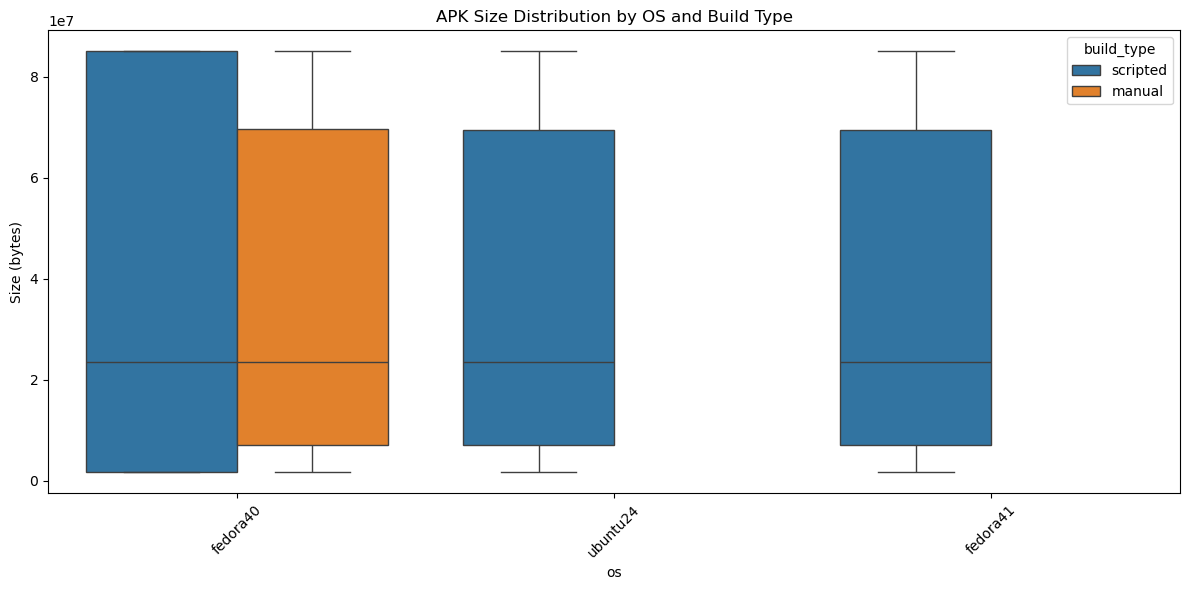

In [35]:
def analyze_size_differences(df):
    """Analyze size differences between builds."""
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='os', y='size', hue='build_type')
    plt.title('APK Size Distribution by OS and Build Type')
    plt.ylabel('Size (bytes)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Calculate size statistics
    size_stats = df.groupby(['os', 'build_type'])['size'].agg(['mean', 'std', 'min', 'max'])
    return size_stats

size_stats = analyze_size_differences(df)
size_stats

## Build Environment Impact Analysis

Let's analyze how different build environments affect the final APK.

os                                                           fedora40  \
build_type                                                     manual   
filename                                                                
base-arm64_v8a.apk  d296fff8691b3632f85725202045875af7e89dafedc9df...   
base-master.apk     eb1902b3aa98e15a140e9de574dfa47b78bf8bb85fc556...   
base-xxhdpi.apk     c65a2691cde28650f8934d492bff6c241b2e55eee4d222...   

os                                                                     \
build_type                                                   scripted   
filename                                                                
base-arm64_v8a.apk  d296fff8691b3632f85725202045875af7e89dafedc9df...   
base-master.apk     eb1902b3aa98e15a140e9de574dfa47b78bf8bb85fc556...   
base-xxhdpi.apk     c65a2691cde28650f8934d492bff6c241b2e55eee4d222...   

os                                                           fedora41  \
build_type                                                   scripted   
filename                                                                
base-arm64_v8a.apk  d296fff8691b3632f85725202045875af7e89dafedc9df...   
base-master.apk     eb1902b3aa98e15a140e9de574dfa47b78bf8bb85fc556...   
base-xxhdpi.apk     c65a2691cde28650f8934d492bff6c241b2e55eee4d222...   

os                                                           ubuntu24  
build_type                                                   scripted  
filename                                                               
base-arm64_v8a.apk  d296fff8691b3632f85725202045875af7e89dafedc9df...  
base-master.apk     eb1902b3aa98e15a140e9de574dfa47b78bf8bb85fc556...  
base-xxhdpi.apk     c65a2691cde28650f8934d492bff6c241b2e55eee4d222...

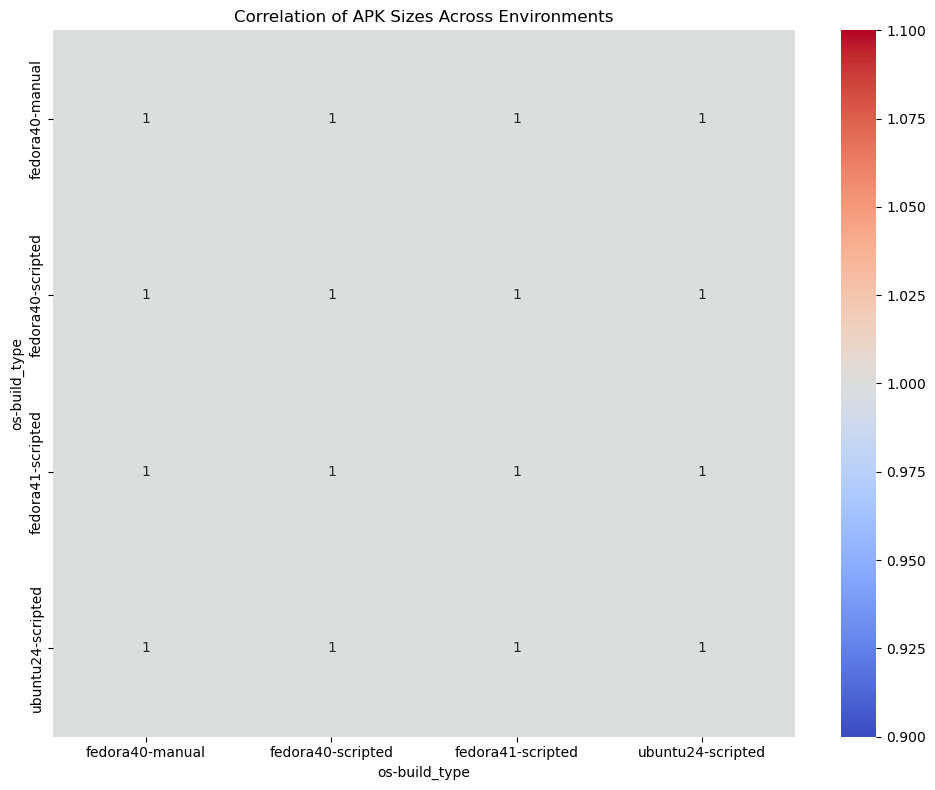

In [36]:
def analyze_environment_impact(df):
    """Analyze the impact of different build environments."""
    # Compare hashes across environments for the same APK
    env_impact = df.pivot_table(
        index='filename',
        columns=['os', 'build_type'],
        values='hash',
        aggfunc='first'
    )
    
    # Calculate correlation of sizes across environments
    size_correlation = df.pivot_table(
        index='filename',
        columns=['os', 'build_type'],
        values='size',
        aggfunc='first'
    ).corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(size_correlation, annot=True, cmap='coolwarm')
    plt.title('Correlation of APK Sizes Across Environments')
    plt.tight_layout()
    
    return env_impact

env_impact = analyze_environment_impact(df)
env_impact.head()

## Conclusions

Based on the analysis above, we can draw the following conclusions:

1. Build Reproducibility: [This will be filled based on actual results]
2. Size Consistency: [This will be filled based on actual results]
3. Environment Impact: [This will be filled based on actual results]

### Recommendations

Based on these findings, here are some recommendations for improving build reproducibility:

1. [Will be filled based on actual results]
2. [Will be filled based on actual results]
3. [Will be filled based on actual results]